# TD3 电磁式阻尼器振动控制训练

本notebook用于训练基于全连接网络架构的TD3算法，用于电磁式阻尼器的振动控制，

## 主要特点
- 使用TD3（Twin Delayed Deep Deterministic Policy Gradient）算法
- 针对电磁式阻尼器系统的振动控制优化

### 训练参数

In [1]:
# 参数设置
# 环境参数
ENV_PARAMS = {
    'Ts': 0.01,  # 采样时间
    'T': 10.0,    # 仿真时长
    'state0':[0.0, 0.0, 0.0, 0.0, 0.01, 0.0], # 初始状态
    # 观测状态列表
    # 0: 吸振器位移 (x1)
    # 1: 吸振器速度 (v1)
    # 2: 吸振器加速度 (a1)
    # 3: 平台位移 (x2)
    # 4: 平台速度 (v2)
    # 5: 平台加速度 (a2)
    'observation_indices': [0,2,3,5],  # 观测状态索引
    'x1_limit': 0.001,      # x1 位移限制
    # 'seq_len': 10,              # GRU序列长度
    'use_time_input': False,    # 无时间感知
    'use_time_noise': False,    # 不使用时间噪声
    'time_noise_std': 0.1       # 时间噪声标准差
}

# TD3参数
TD3_PARAMS = {
    'state_dim': len(ENV_PARAMS['observation_indices']),  # 观测维度（平台位移）
    'hidden_dim': 64,          # 隐藏层维度
    'action_bound': 5.0,        # 动作范围
    'actor_lr': 5e-4,           # Actor学习率
    'critic_lr': 1e-3,          # Critic学习率
    'gamma': 0.99,              # 折扣因子
    'tau': 0.005,               # 软更新参数
    'policy_noise': 0.1,        # 策略噪声
    'noise_clip': 0.3,          # 噪声裁剪
    'policy_freq': 2,           # 策略更新频率
    'sigma': 0.02,               # 探索噪声
    'rand_prob': 0,          # 随机动作概率
    'clip_grad': True           # 是否裁剪梯度
}

# 训练参数
TRAIN_PARAMS = {
    'tolerance': 0.0001,          # 容忍度
    'n_episodes': 400,           # 训练轮次
    'capacity': int(1e6),       # 经验回放池容量
    'min_buffer_size': int(5e3),# 最小缓冲区大小
    'print_interval': 5,        # 打印间隔
    'save_interval': 5,         # 保存间隔
    'batch_size': 128,           # 批次大小
    }

### 仿真环境搭建

In [2]:
train_model = True

import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
from datetime import datetime
import os

# 导入自定义模块
from TD3 import TD3Agent
from nn import ReplayBuffer
from env import ElectromagneticDamperEnv
from train import train_td3
from af import Datasets, STATES_NAME

# 设置中文字体和GPU
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 设置随机种子
# np.random.seed(42)
# torch.manual_seed(42)
print(f"使用设备: {device}")

使用设备: cuda


In [3]:
# 日志文件
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
# 创建保存模型的基础目录
base_dir = ".\\savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认项目文件夹
project_name = input("请输入加载/创建项目的名称 (父目录: .\\savedata) ").strip()
project_path = os.path.join(base_dir, project_name)

# 检查项目文件夹是否存在
is_new_project = not os.path.exists(project_path)
os.makedirs(project_path, exist_ok=True)

# 创建检查点保存目录
save_checkpoint_path = os.path.join(project_path, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)

# 创建绘图保存目录
save_plot_path = os.path.join(project_path, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = os.path.join(project_path, f'training_log_{current_time}.log')
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = os.path.join(project_path, f'training_log_{current_time}.log')

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", project_path)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)
logging.info("环境参数: %s", ENV_PARAMS)
logging.info("算法参数: %s", TD3_PARAMS)
logging.info("训练参数: %s", TRAIN_PARAMS)
print(f"日志文件: {file_path}")

日志文件: .\savedata\8_16下午全连接TD3训练（初始探索不宜过高，效果好的爆炸）\training_log_20250816_160226.log


In [4]:
# 系统参数
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000  # 电磁吸振器刚度
k_M = 20000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 1.0  # 电磁吸振器阻尼
c_M = 5.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T
logging.info("系统参数: m=%.2f, M=%.2f, k_m=%.2f, k_M=%.2f, k_f=%.2f, k_E=%.2f, L=%.4f, R_m=%.2f, c_m=%.2f, c_M=%.2f", 
             m, M, k_m, k_M, k_f, k_E, L, R_m, c_m, c_M)

In [5]:
# 定义扰动函数和奖励函数
import inspect

from fx import z_zero
z_func = z_zero
from fx import tolerance_if_rf
r_func = tolerance_if_rf(tolerance=TRAIN_PARAMS['tolerance'])

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))
if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))

In [6]:
# 初始化环境
env = ElectromagneticDamperEnv(
    A=A, B=B, C=C, D=D, E=E,
    Ts=ENV_PARAMS['Ts'],  # 采样时间
    T=ENV_PARAMS['T'],    # 仿真时长
    z_func=z_func,
    r_func=r_func,
    state0=np.array(ENV_PARAMS['state0']),  # 初始状态
    obs_indices=ENV_PARAMS['observation_indices'],  # 观测状态索引
    x1_limit=ENV_PARAMS['x1_limit'],  # x1 位移限制
    use_time_input=ENV_PARAMS['use_time_input'],  # 是否使用时间作为输入
    use_time_noise=ENV_PARAMS['use_time_noise'], # 是否使用时间噪声
    time_noise_std=ENV_PARAMS['time_noise_std'] # 时间噪声标准差
)

logging.info("环境初始化完成，观测维度: %s", [STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']])
print(f"环境初始化完成，观测维度: {[STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']]}")

环境初始化完成，观测维度: ['吸振器位移 (x1)', '吸振器加速度 (a1)', '平台位移 (x2)', '平台加速度 (a2)']


仿真进度: 1001it [00:00, 11447.16it/s]            


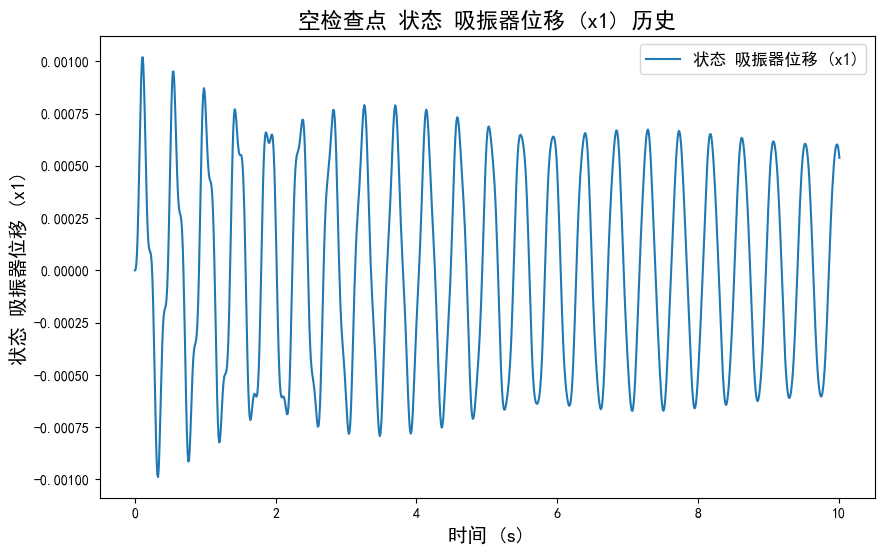

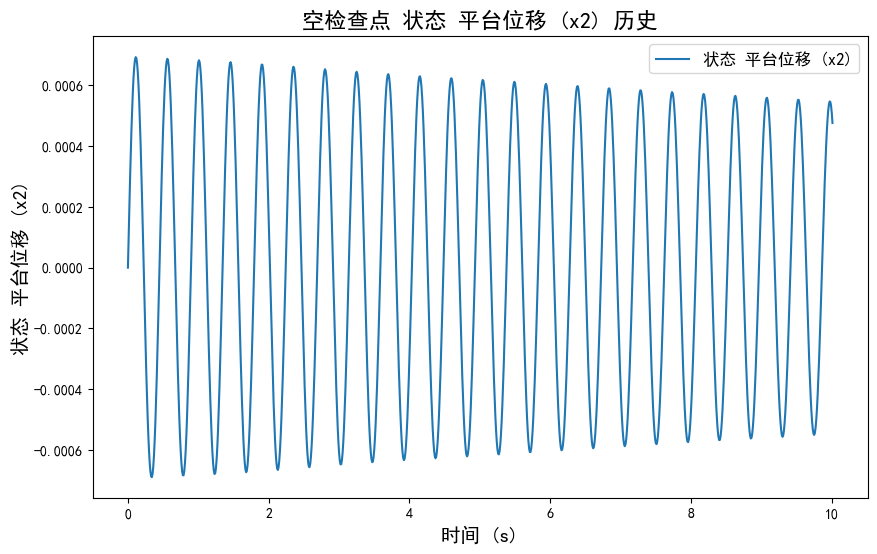

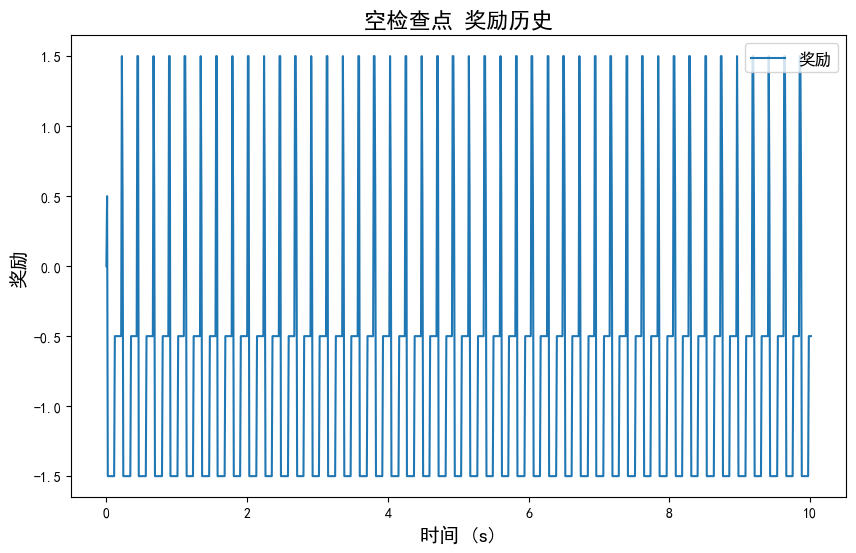

In [7]:
# 环境测试
test_datasets = env.run_simulation()
test_datasets.plot_episode_history(plot_state=[0, 3], plot_reward=True, save_path=save_plot_path, show=True)

In [8]:
# 初始化GRU-TD3代理
agent = TD3Agent(
    state_dim=len(ENV_PARAMS['observation_indices']),  # 观测维度
    action_dim=1,
    hidden_dim=TD3_PARAMS['hidden_dim'],
    action_bound=TD3_PARAMS['action_bound'],
    actor_lr=TD3_PARAMS['actor_lr'],
    critic_lr=TD3_PARAMS['critic_lr'],
    gamma=TD3_PARAMS['gamma'],
    tau=TD3_PARAMS['tau'],
    policy_noise=TD3_PARAMS['policy_noise'],
    noise_clip=TD3_PARAMS['noise_clip'],
    policy_freq=TD3_PARAMS['policy_freq'],
    sigma=TD3_PARAMS['sigma'],
    clip_grad=TD3_PARAMS['clip_grad']
)
logging.info("TD3代理初始化完成")
print("TD3代理初始化完成")

# 写入网络架构到日志
logging.info(f"Actor网络架构:{agent.actor}")
logging.info(f"Critic网络架构:{agent.critic1}")

# 初始化经验回放池
replay_buffer = ReplayBuffer(
    capacity=TRAIN_PARAMS['capacity'],  # 经验回放池容量
    batch_size=TRAIN_PARAMS['batch_size'],
)
logging.info("经验回放池初始化完成")
print("经验回放池初始化完成")

TD3代理初始化完成
经验回放池初始化完成


### 训练

In [ ]:
# 开始训练
logging.info("开始TD3训练（全连接版本）")
train_datasets = Datasets()

# 加载先前训练的模型（如果存在）
start_episode = train_datasets.load_datasets(agent, save_checkpoint_path)
logging.info(f"从第 {start_episode} 轮开始训练")
print(f"从第 {start_episode} 轮开始训练")

try:
    # 执行训练
    train_datasets = train_td3(
        env=env,
        agent=agent,
        replay_buffer=replay_buffer,
        n_episodes=TRAIN_PARAMS['n_episodes'], # 训练轮次
        min_buffer_size=TRAIN_PARAMS['min_buffer_size'], # 最小缓冲池大小
        print_interval=TRAIN_PARAMS['print_interval'], # 打印间隔
        save_interval=TRAIN_PARAMS['save_interval'], # 保存间隔
        project_path=project_path,
        save_checkpoint_path=save_checkpoint_path,
        save_plot_path=save_plot_path,
        rand_prob=TD3_PARAMS['rand_prob'],  # 随机动作概率
        train_datasets=train_datasets  # 数据集对象
    )
    
    print("训练完成！")
    logging.info("训练完成！")
    
except KeyboardInterrupt:
    print("训练被用户中断")
    logging.info("训练被用户中断")
except Exception as e:
    print(f"训练过程中发生错误: {e}")
    logging.error(f"训练过程中发生错误: {e}")
    raise

从第 0 轮开始训练


仿真进度: 1001it [00:00, 11188.42it/s]            
仿真进度: 1001it [00:00, 1349.10it/s]                         
仿真进度: 1001it [00:00, 1340.04it/s]                         
仿真进度: 1001it [00:00, 1355.33it/s]                         
仿真进度: 1001it [00:00, 1275.93it/s]                         
仿真进度: 1001it [00:00, 1337.26it/s]                         
仿真进度: 1001it [00:00, 1343.34it/s]                         
仿真进度: 1001it [00:00, 1360.57it/s]                         
仿真进度: 1001it [00:00, 1366.38it/s]                         
仿真进度: 1001it [00:00, 1319.02it/s]                         
仿真进度: 1001it [00:00, 1323.81it/s]                         
仿真进度: 1001it [00:00, 1323.73it/s]                         
仿真进度: 1001it [00:00, 1332.13it/s]                         
仿真进度: 1001it [00:00, 1331.63it/s]                         
仿真进度: 1001it [00:00, 1295.88it/s]                         
仿真进度: 1001it [00:00, 1281.24it/s]                         
仿真进度: 1001it [00:00, 1307.66it/s]                         
仿真进度: 100

In [ ]:
# 训练结果分析和可视化
if 'final_rewards' in locals():
    print("="*60)
    print("训练结果分析")
    print("="*60)
    
    # 绘制训练奖励曲线
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(final_rewards, alpha=0.6, label='Episode Reward')
    if len(final_rewards) > 10:
        # 计算移动平均
        window = min(10, len(final_rewards) // 4)
        moving_avg = np.convolve(final_rewards, np.ones(window)/window, mode='valid')
        plt.plot(np.arange(window-1, len(final_rewards)), moving_avg, 
                'r-', linewidth=2, label=f'{window}-Episode Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('训练奖励曲线（无时间感知GRU-TD3）')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(avg_rewards, 'g-', linewidth=2, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('平均奖励曲线')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_path), 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印统计信息
    print(f"总训练轮次: {len(final_rewards)}")
    print(f"最终平均奖励: {np.mean(final_rewards[-10:]):.2f}")
    print(f"最高单轮奖励: {np.max(final_rewards):.2f}")
    print(f"最低单轮奖励: {np.min(final_rewards):.2f}")
    print(f"奖励标准差: {np.std(final_rewards):.2f}")
    
    logging.info(f"训练统计 - 平均奖励: {np.mean(final_rewards[-10:]):.2f}, "
                f"最高奖励: {np.max(final_rewards):.2f}, "
                f"最低奖励: {np.min(final_rewards):.2f}")

else:
    print("训练未完成或发生错误，无法进行结果分析")

训练未完成或发生错误，无法进行结果分析


In [ ]:
# 模型测试和性能评估
print("="*60)
print("模型性能测试")
print("="*60)

# 测试训练好的模型
print("运行控制仿真测试...")
test_data_with_control = env.run_simulation(controller=agent)

print("运行无控制仿真对比...")
test_data_no_control = env.run_simulation(controller=None)

# 计算性能指标
def calculate_performance_metrics(controlled_data, uncontrolled_data):
    """计算控制性能指标"""
    # 主结构位移（索引3）
    x2_controlled = controlled_data['all_states'][:, 3]
    x2_uncontrolled = uncontrolled_data['all_states'][:, 3]
    
    # RMS值
    rms_controlled = np.sqrt(np.mean(x2_controlled**2))
    rms_uncontrolled = np.sqrt(np.mean(x2_uncontrolled**2))
    
    # 最大值
    max_controlled = np.max(np.abs(x2_controlled))
    max_uncontrolled = np.max(np.abs(x2_uncontrolled))
    
    # 减振效果
    rms_reduction = (rms_uncontrolled - rms_controlled) / rms_uncontrolled * 100
    max_reduction = (max_uncontrolled - max_controlled) / max_uncontrolled * 100
    
    # 控制能耗
    control_energy = np.sum(np.array(controlled_data['actions'][1:])**2) * env.Ts
    
    return {
        'rms_controlled': rms_controlled,
        'rms_uncontrolled': rms_uncontrolled,
        'rms_reduction': rms_reduction,
        'max_controlled': max_controlled,
        'max_uncontrolled': max_uncontrolled,
        'max_reduction': max_reduction,
        'control_energy': control_energy
    }

metrics = calculate_performance_metrics(test_data_with_control, test_data_no_control)

print(f"性能指标（无时间感知GRU-TD3）:")
print(f"  RMS位移减少: {metrics['rms_reduction']:.1f}%")
print(f"  最大位移减少: {metrics['max_reduction']:.1f}%") 
print(f"  有控制RMS: {metrics['rms_controlled']:.4f} m")
print(f"  无控制RMS: {metrics['rms_uncontrolled']:.4f} m")
print(f"  有控制最大位移: {metrics['max_controlled']:.4f} m")
print(f"  无控制最大位移: {metrics['max_uncontrolled']:.4f} m")
print(f"  控制能耗: {metrics['control_energy']:.4f}")

logging.info(f"性能测试结果 - RMS减少: {metrics['rms_reduction']:.1f}%, "
            f"最大位移减少: {metrics['max_reduction']:.1f}%, "
            f"控制能耗: {metrics['control_energy']:.4f}")

模型性能测试
运行控制仿真测试...


仿真进度: 1001it [00:01, 944.17it/s]                          


运行无控制仿真对比...


仿真进度: 1001it [00:00, 11033.81it/s]            


TypeError: 'Datasets' object is not subscriptable

In [ ]:
# 对比可视化分析
print("="*60)
print("生成对比图表")
print("="*60)

# 设置时间轴
time_test = np.arange(len(test_data_with_control['all_states'])) * env.Ts

# 创建对比图
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# 位移对比
axes[0].plot(time_test, test_data_with_control['all_states'][:, 3], 'b-', 
            label='有控制(GRU-TD3)', linewidth=1.5)
axes[0].plot(time_test, test_data_no_control['all_states'][:, 3], 'r--', 
            label='无控制', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('位移 (m)')
axes[0].set_title('主结构位移响应对比')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 速度对比
axes[1].plot(time_test, test_data_with_control['all_states'][:, 4], 'b-', 
            label='有控制(GRU-TD3)', linewidth=1.5)
axes[1].plot(time_test, test_data_no_control['all_states'][:, 4], 'r--', 
            label='无控制', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('速度 (m/s)')
axes[1].set_title('主结构速度响应对比')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 控制力时程
axes[2].plot(time_test[1:], test_data_with_control['actions'][1:], 'g-', 
            label='GRU-TD3控制力', linewidth=1.5)
axes[2].set_ylabel('控制力 (N)')
axes[2].set_xlabel('时间 (s)')
axes[2].set_title('控制力时程')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{plot_dir}/performance_comparison_gru_td3.png', dpi=300, bbox_inches='tight')
plt.show()

# 频域分析
from scipy import signal

# 计算功率谱密度
freq, psd_controlled = signal.welch(test_data_with_control['all_states'][:, 3], 
                                   fs=1/env.Ts, nperseg=1024)
freq, psd_uncontrolled = signal.welch(test_data_no_control['all_states'][:, 3], 
                                     fs=1/env.Ts, nperseg=1024)

plt.figure(figsize=(10, 6))
plt.semilogy(freq, psd_controlled, 'b-', label='有控制(GRU-TD3)', linewidth=2)
plt.semilogy(freq, psd_uncontrolled, 'r--', label='无控制', linewidth=2, alpha=0.7)
plt.xlabel('频率 (Hz)')
plt.ylabel('功率谱密度 (m²/Hz)')
plt.title('位移响应功率谱密度对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 5)  # 关注0-5Hz范围
plt.savefig(f'{plot_dir}/psd_comparison_gru_td3.png', dpi=300, bbox_inches='tight')
plt.show()

print("所有分析图表已保存完成！")
print(f"图表保存路径: {plot_dir}")
logging.info("GRU-TD3训练和测试完成，所有结果已保存")